In [82]:
"""
https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt
https://www.kaggle.com/competitions/1056lab-import-car-insurance-prediction/overview/description

This data set is about import cars assigned insurance risk rating in 1985. The rating corresponds to the degree to which the auto is riskier than its price indicates.
Cars are initially assigned a risk factor symbol associated with its price. Then, if it is riskier (or less), this symbol is adjusted by moving it up (or down) the scale. 
Actuaries call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [83]:
def jointplots(xs, y, data, hue=None, height=6, ratio=5, space=0.2, xlabels=None, ylabel=None, margin_norm=False):
    """
    -------------------
    Input Parameters
    -------------------
    xs      : (list or str) feature name(s) of data
    y       : (str) feature name of data
    data    : (pandas.DataFrame)
    hue     : (str) semantic variable that is mapped to determine the color of plot elements. Semantic variable that is mapped to determine the color of plot elements.
    
    height  : (float) size of the figure
    ratio   : (float) ratio of the joint axes height to marginal axes height.
    space   : (float) space between the joint and marginal axes
    
    xlabels : (list or str) xlabels
    ylabel  : (str) ylabel
    margin_norm : (boolean) if True, kdeplots at marginal axes have same scale.
    """
    ### 1. input check
    # input type
    assert isinstance(xs, list) or isinstance(xs, str)
    if isinstance(xs, list):
        assert all([isinstance(x, str) for x in xs])
    else:
        xs = [xs]
        
    
    if xlabels != None:
        assert isinstance(xlabels, list) or isinstance(xlabels, str)
        if isinstance(xlabels, list):
            assert all([isinstance(xlabel, str) for xlabel in xlabels])
        else:
            xlabels = [xlabels]
    
    if ylabel != None:
        assert isinstance(ylabel, str)
    
    if hue != None:
        assert isinstance(hue, str)
    
    # input data
    assert all([x in data.columns for x in xs])
    assert y in data.columns
    if hue != None:
        assert hue in data.columns
    
    
    ### 2. figure
    h_margin = height / (ratio + 1)
    h_joint = height - h_margin
    
    if isinstance(xs, list):
        n_x = len(xs)
    else:
        n_x = 1
    
    widths = [h_joint] * n_x + [h_margin]
    heights = [h_margin, h_joint]
    ncols = len(widths)
    nrows = len(heights)
    
    fig = plt.figure(figsize=(sum(widths), sum(heights)))
    
    ### 3. gridspec preparation
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, 
                            width_ratios = widths, height_ratios = heights,
                            wspace=space, hspace=space
                           )
    
    ### 4. setting axes
    axs = {}
    for i in range(ncols * nrows):
        axs[i] = fig.add_subplot(spec[i//ncols, i%ncols])
    
    
    ### 5. jointplots (scatterplot + kdeplot)
    for i, x in enumerate(xs, ncols):
        if i == ncols:
            legend=True
        else:
            legend=False
        sns.kdeplot(x=x, y=y, data=data, hue=hue, alpha=0.3, ax=axs[i], zorder=2, legend=False)
        sns.scatterplot(x=x, y=y, data=data, hue=hue, alpha=0.8, ax=axs[i], zorder=3, legend=legend)
    
    
    ### 6. kdeplots at marginal axes
    axs[ncols-1].axis("off")
    
    axes_mx = list(range(ncols-1))
    axes_my = 2*ncols - 1
    
    for i, x in zip(axes_mx, xs):
        sns.kdeplot(x=x, data=data, hue=hue, fill=True, ax=axs[i], zorder=2, legend=False)
        axs[i].set_xlim(axs[i+ncols].get_xlim())
        axs[i].set_xlabel("")
        axs[i].set_xticklabels([])
        axs[i].spines["left"].set_visible(False)
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
    
    sns.kdeplot(y=y, data=data, hue=hue, fill=True, ax=axs[axes_my], zorder=2, legend=False)
    axs[axes_my].set_ylim(axs[ncols].get_ylim())
    axs[axes_my].set_ylabel("")
    axs[axes_my].set_yticklabels([])
    axs[axes_my].spines["bottom"].set_visible(False)
    axs[axes_my].spines["top"].set_visible(False)
    axs[axes_my].spines["right"].set_visible(False)
    
    if margin_norm == True:
        hist_range_max = max([axs[m].get_ylim()[-1] for m in axes_mx] + [axs[axes_my].get_xlim()[-1]])
        for i in axes_mx:
            axs[i].set_ylim(0, hist_range_max)
        axs[axes_my].set_xlim(0, hist_range_max)
        
        
    ### 7. unnecessary elements removal
    # 7.1. labels and ticklabels
    axes_j = list(range(ncols, 2*ncols-1))
    for i in axes_j:
        if i != ncols:
            axs[i].set_ylabel("")
            axs[i].set_yticklabels([])
    
    # 7.2. marginal axes
    for i in axes_mx:
        if i != 0:
            axs[i].set_ylabel("")
        
        axs[i].grid("on", color="lightgray", zorder=0)
        axs[i].set_yticklabels([])
        
        yticks = axs[i].get_yticks()
        ylim = axs[i].get_ylim()
        for ytick in yticks:
            if 0 < ytick < ylim[-1]:
                axs[i].text(axs[i].get_xlim()[0], ytick, str(ytick), 
                            fontdict={"verticalalignment":"center"})
        
    axs[axes_my].grid("on", color="lightgray", zorder=0)
    axs[axes_my].set_xticklabels([])
    axes_my_xticks = axs[axes_my].get_xticks()
    axes_my_xlim = axs[axes_my].get_xlim()
    for xtick in axes_my_xticks:
        if 0 < xtick < axes_my_xlim[-1]:
            axs[axes_my].text(xtick, axs[axes_my].get_ylim()[0], str(xtick), 
                              rotation=270, fontdict={"horizontalalignment":"center"})
    
    # 7.3. labels
    font_label = {"color": "gray", "fontsize":"large"}
    labelpad = 12
    for i, x in zip(axes_j, xlabels):
        axs[i].set_xlabel(x, fontdict=font_label, labelpad=labelpad)
        if i == ncols:
            axs[i].set_ylabel(ylabel, fontdict=font_label, labelpad=labelpad)
    
    axs[0].set_ylabel("Density", fontdict=font_label, labelpad=labelpad)
    axs[2*ncols-1].set_xlabel("Density", fontdict=font_label, labelpad=labelpad)
    
    fig.align_ylabels([axs[0], axs[ncols]])
    fig.align_xlabels([axs[x] for x in range(ncols, 2*ncols)])
    plt.tight_layout()
    
    return fig, axs

In [84]:
# read data
train = pd.read_csv('/kaggle/input/1056lab-car-insurance-risk-prediction/train.csv')
test = pd.read_csv('/kaggle/input/1056lab-car-insurance-risk-prediction/train.csv')
train.head()

,id,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,2,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,3
1,7,158,audi,gas,std,four,sedan,fwd,front,105.8,...,mpfi,3.19,3.4,8.5,110,5500,19,25,17710,1
2,8,?,audi,gas,std,four,wagon,fwd,front,105.8,...,mpfi,3.19,3.4,8.5,110,5500,19,25,18920,1
3,10,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,mpfi,3.13,3.4,7.0,160,5500,16,22,?,0
4,11,192,bmw,gas,std,two,sedan,rwd,front,101.2,...,mpfi,3.5,2.8,8.8,101,5800,23,29,16430,2


In [85]:
# set Target
Target = 'symboling'

In [86]:
# 전처리
train['normalized-losses'] = train['normalized-losses'].replace('?',np.nan).astype(float)
train['price'] = train['price'].replace('?',np.nan).astype(float)
train['bore'] = train['bore'].replace('?',np.nan).astype(float)
train['stroke'] = train['stroke'].replace('?',np.nan).astype(float)
train['horsepower'] = train['horsepower'].replace('?',np.nan).astype(float)
train['peak-rpm'] = train['peak-rpm'].replace('?',np.nan).astype(float)

> eda for regresion

In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

def eda_plot(data,col_name,Target,hue=None,TopN=100):
    
    train_copy = data.copy()
    
    if data[col_name].dtype in ['object']:
        
        cat_col = col_name
        
        # select top N values in cat feature 
        top_values = train_copy[cat_col].value_counts().head(TopN).index.tolist()
        train_copy = train_copy.loc[train_copy[cat_col].isin(top_values),:].reset_index(drop=True)
    
        # plot figsize and title 
        plt.figure(figsize=(20,5))
        plt.suptitle('({cat_col}) Distributions'.format(cat_col=cat_col), fontsize=22)
        
        # check 
        a1 = train_copy.groupby(cat_col)[Target].agg([len,np.mean,np.sum]).reset_index().sort_values(['len'],ascending=False)
        display(a1.head(10))

        # target mean group by cat
        plt.subplot(121)
        g1 = sns.countplot(x=cat_col, data=train_copy)
        gt = g1.twinx()
        a1 = train_copy.groupby(cat_col)[Target].mean()
        a1 = a1.sort_index(ascending=False).reset_index()
        gt = sns.pointplot(x=cat_col, y=Target, data=a1, color='black', legend=False)
        gt.set_ylabel("mean of Target", fontsize=16)
        g1.set_title("bar plot & target mean", fontsize=19)
        g1.set_xlabel("{cat_col}".format(cat_col=cat_col), fontsize=17)
        g1.set_ylabel("Count", fontsize=17)
        g1.set_xticklabels(g1.get_xticklabels(),rotation=90)

        # boxplot 
        plt.subplot(122)
        ax = sns.stripplot(x=cat_col, y=Target, data=train_copy, dodge=True, jitter=True, alpha=.25)
        g3 = sns.violinplot(x=cat_col, y=Target, data=train_copy, ax=ax, color=".8")
        g3.set_title("violin & strip plot", fontsize=20)
        g3.set_xlabel("{cat_col}".format(cat_col=cat_col), fontsize=17)
        g3.set_ylabel("{Target}".format(Target=Target), fontsize=17)
        g3.set_xticklabels(g3.get_xticklabels(),rotation=90)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
        plt.show()
        
    elif data[col_name].dtype in [int,float]:
        
        num_col = col_name
        
        # check 
        a1 = train_copy.groupby(Target)[num_col].agg([len,np.mean,max,min]).reset_index().sort_values(['len'],ascending=False)
        display(a1.head(10))
        
        # jointplot 
        g2 = sns.jointplot(data=train_copy, x=num_col, y=Target, marker="+",height=7,hue=hue)
        g2.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
        g2.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

        plt.show()

normalized-losses


,symboling,len,mean,max,min
2,0,52,112.722222,188.0,77.0
3,1,36,130.833333,231.0,87.0
5,3,19,170.769231,256.0,142.0
4,2,18,129.562500,192.0,83.0
1,-1,16,91.866667,137.0,65.0
0,-2,3,103.000000,103.0,103.0


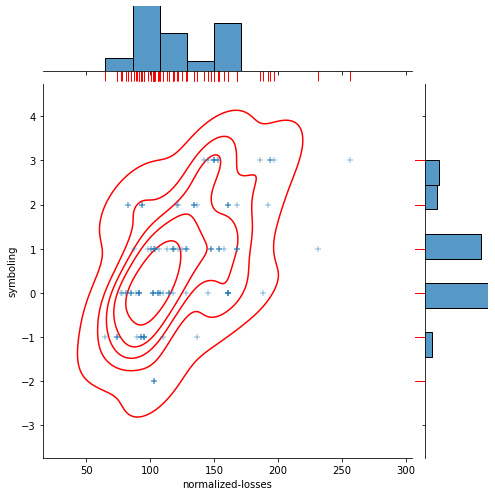

make


,make,len,mean,sum
19,toyota,17,0.647059,11
12,nissan,13,1.076923,14
8,mazda,12,0.833333,10
21,volvo,10,-1.300000,-13
5,honda,10,0.500000,5
20,volkswagen,9,1.555556,14
13,peugot,9,0.000000,0
11,mitsubishi,9,2.000000,18
4,dodge,8,1.000000,8
18,subaru,8,0.500000,4


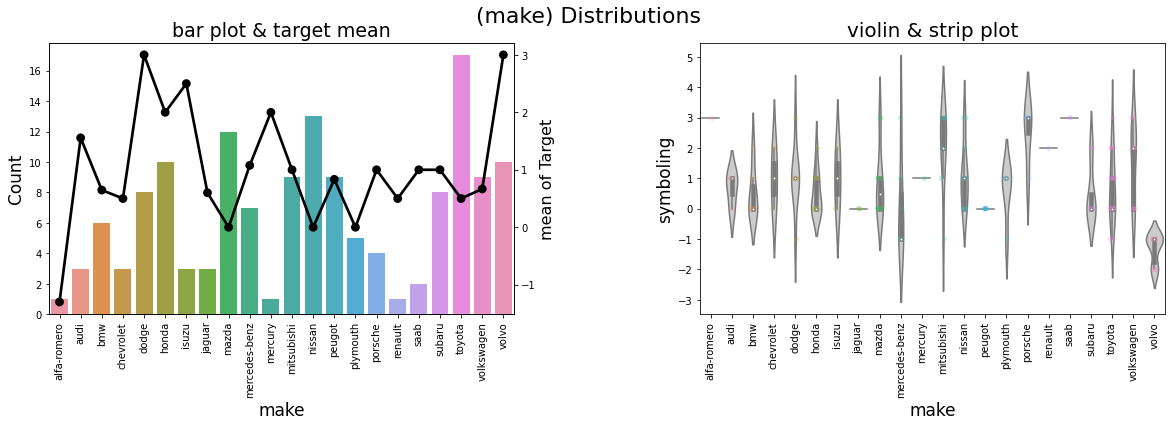

fuel-type


,fuel-type,len,mean,sum
1,gas,127,0.834646,106
0,diesel,17,0.058824,1


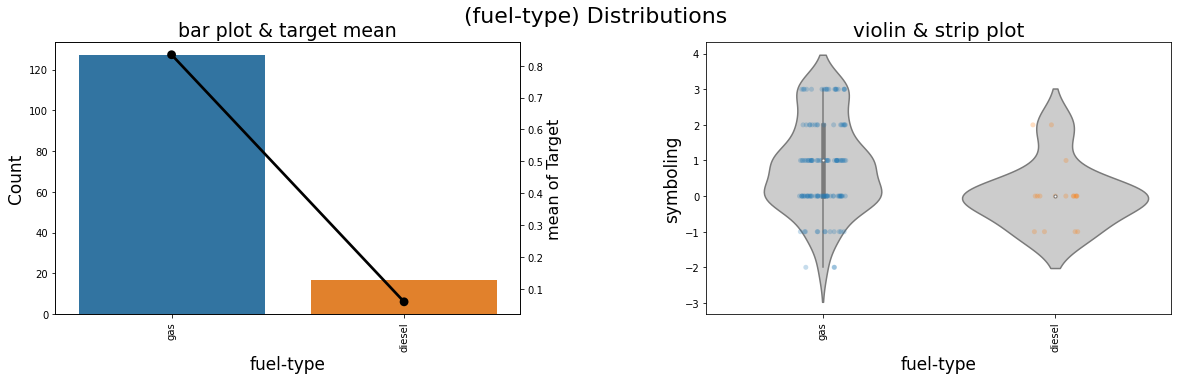

aspiration


,aspiration,len,mean,sum
0,std,117,0.803419,94
1,turbo,27,0.481481,13


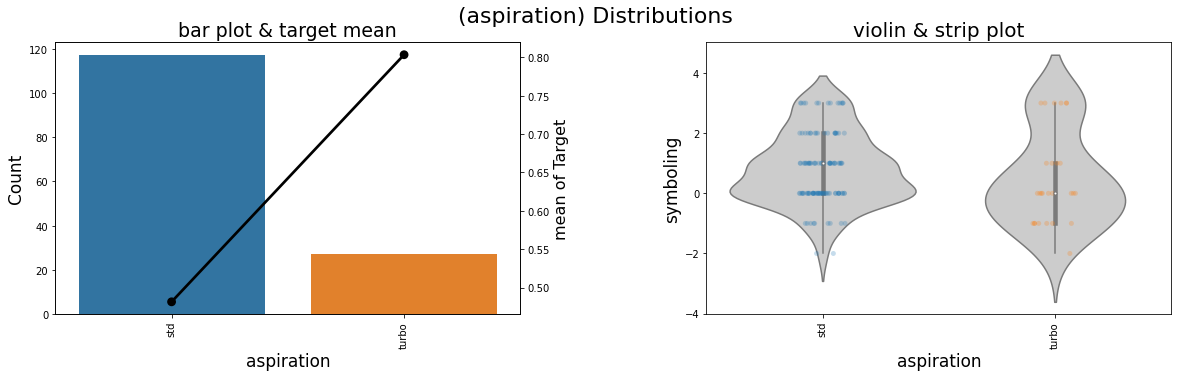

num-of-doors


,num-of-doors,len,mean,sum
1,four,81,-0.037037,-3
2,two,61,1.786885,109
0,?,2,0.500000,1


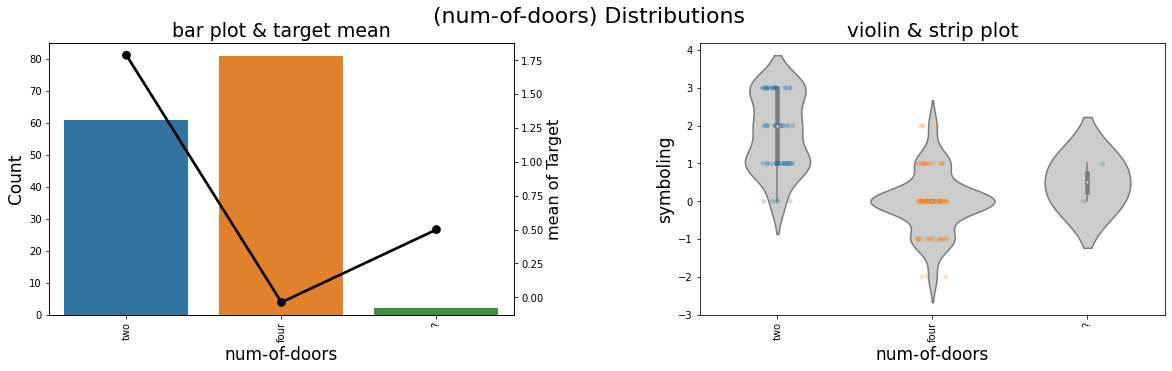

body-style


,body-style,len,mean,sum
3,sedan,68,0.102941,7
2,hatchback,48,1.666667,80
4,wagon,19,-0.105263,-2
1,hardtop,5,2.000000,10
0,convertible,4,3.000000,12


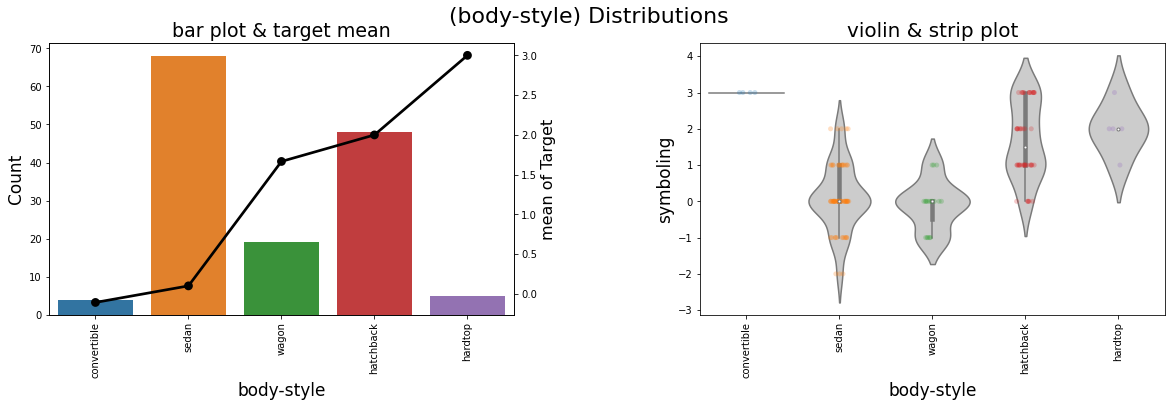

drive-wheels


,drive-wheels,len,mean,sum
1,fwd,81,0.950617,77
2,rwd,58,0.517241,30
0,4wd,5,0.000000,0


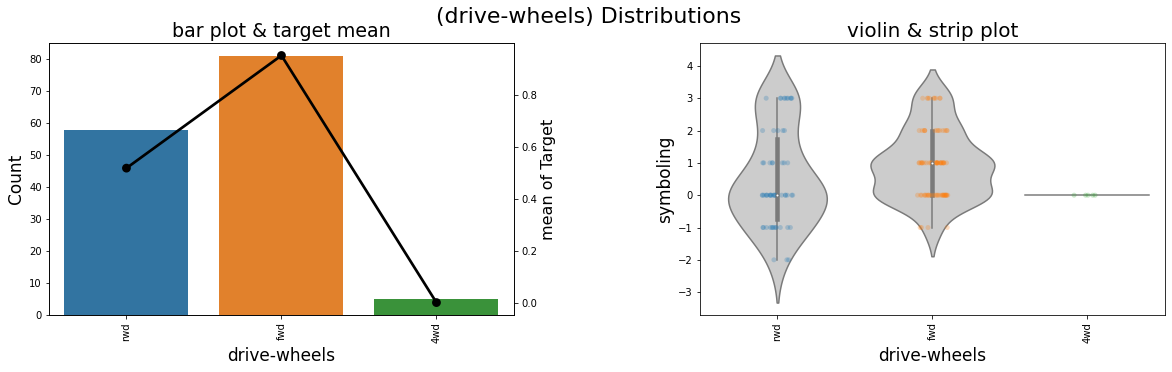

engine-location


,engine-location,len,mean,sum
0,front,142,0.711268,101
1,rear,2,3.000000,6


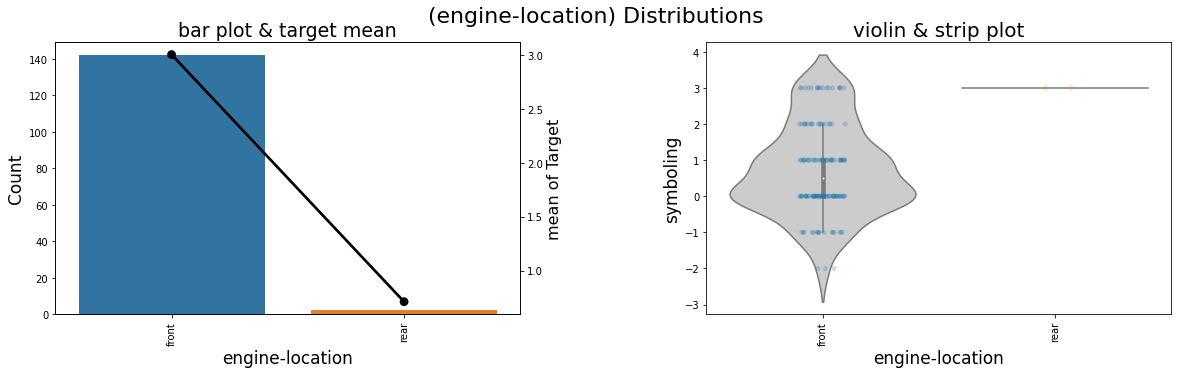

wheel-base


,symboling,len,mean,max,min
2,0,52,101.567308,120.9,94.3
3,1,36,96.205556,112.0,93.1
5,3,19,94.857895,102.9,88.6
4,2,18,95.350000,101.2,86.6
1,-1,16,107.193750,115.6,96.3
0,-2,3,104.300000,104.3,104.3


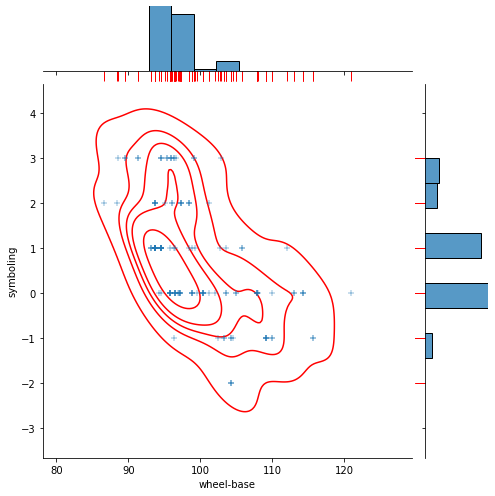

length


,symboling,len,mean,max,min
2,0,52,179.325000,208.1,157.1
3,1,36,167.122222,199.2,150.0
5,3,19,172.763158,186.6,159.3
4,2,18,165.355556,176.8,141.1
1,-1,16,187.100000,202.6,172.4
0,-2,3,188.800000,188.8,188.8


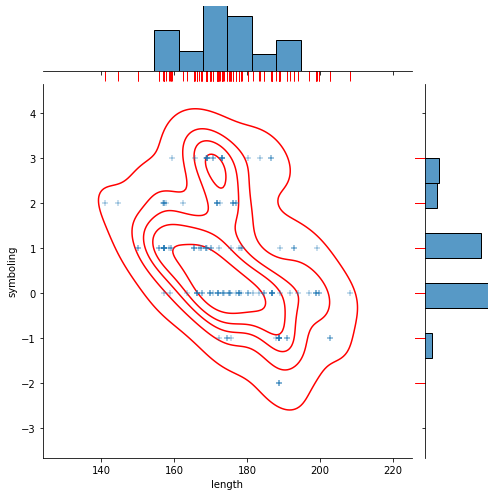

width


,symboling,len,mean,max,min
2,0,52,66.369231,71.7,61.8
3,1,36,65.227778,72.3,63.6
5,3,19,66.247368,70.5,64.0
4,2,18,64.644444,66.6,60.3
1,-1,16,68.150000,71.7,64.6
0,-2,3,67.200000,67.2,67.2


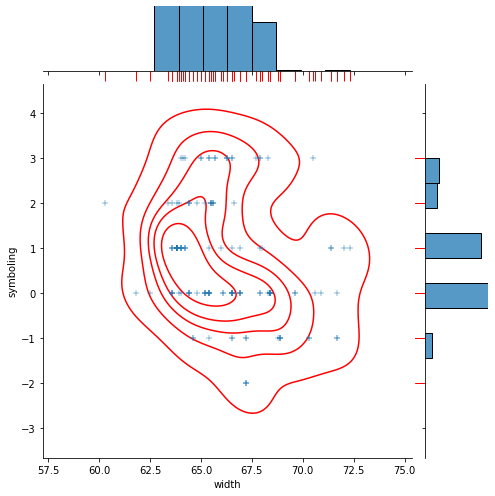

height


,symboling,len,mean,max,min
2,0,52,54.894231,59.1,47.8
3,1,36,52.647222,55.7,49.7
5,3,19,51.168421,56.1,48.8
4,2,18,52.894444,55.7,50.5
1,-1,16,56.293750,59.8,51.6
0,-2,3,56.200000,56.2,56.2


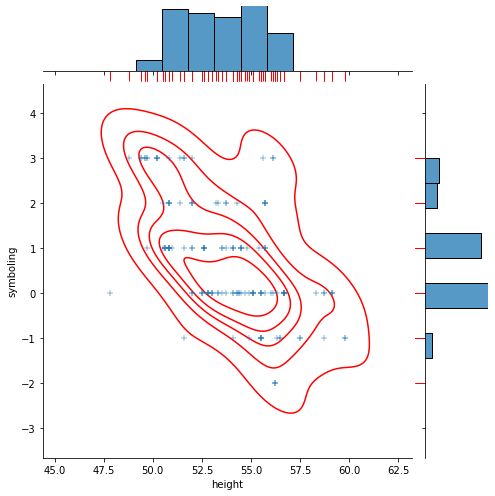

curb-weight


,symboling,len,mean,max,min
2,0,52,2761.769231,4066,1909
3,1,36,2251.722222,3715,1837
5,3,19,2735.526316,3685,2221
4,2,18,2200.222222,2734,1488
1,-1,16,3074.250000,3770,2326
0,-2,3,2964.000000,3045,2912


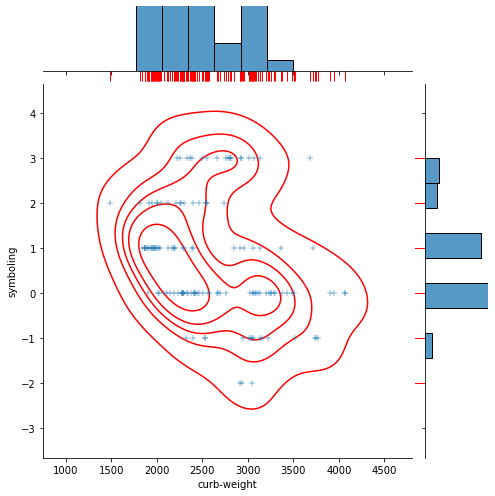

engine-type


,engine-type,len,mean,sum
3,ohc,102,0.686275,70
5,ohcv,12,0.750000,9
2,l,10,0.200000,2
4,ohcf,10,1.000000,10
0,dohc,7,1.285714,9
6,rotor,2,3.000000,6
1,dohcv,1,1.000000,1


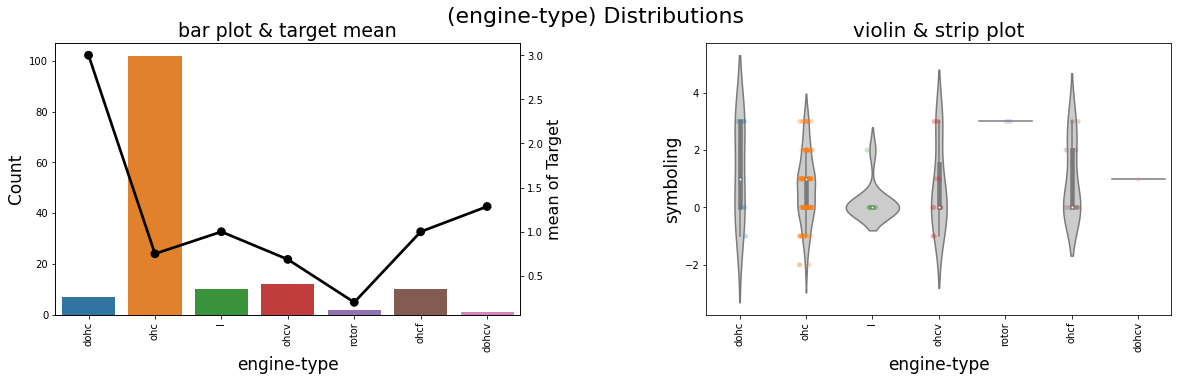

num-of-cylinders


,num-of-cylinders,len,mean,sum
2,four,109,0.752294,82
3,six,19,0.736842,14
1,five,7,-0.142857,-1
0,eight,5,0.800000,4
6,two,2,3.000000,6
4,three,1,2.000000,2
5,twelve,1,0.000000,0


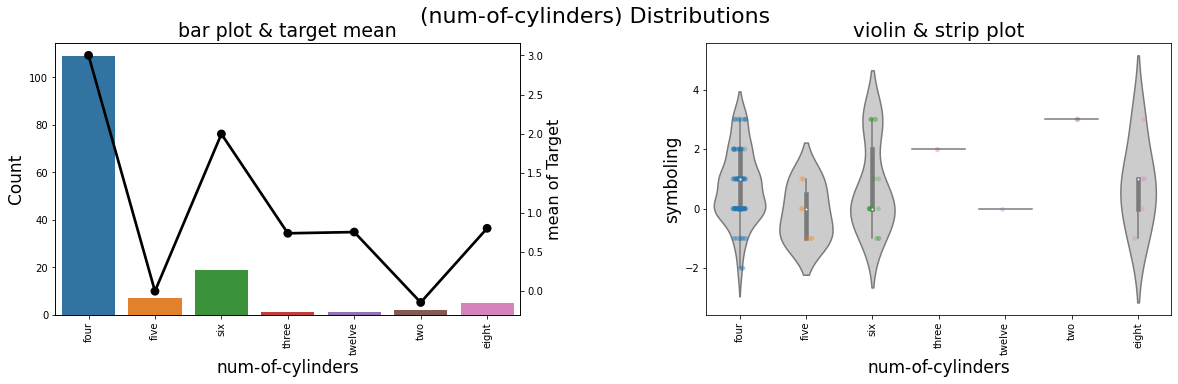

engine-size


,symboling,len,mean,max,min
2,0,52,139.576923,326,90
3,1,36,111.972222,304,79
5,3,19,144.526316,234,70
4,2,18,107.777778,146,61
1,-1,16,152.625000,234,110
0,-2,3,137.333333,141,130


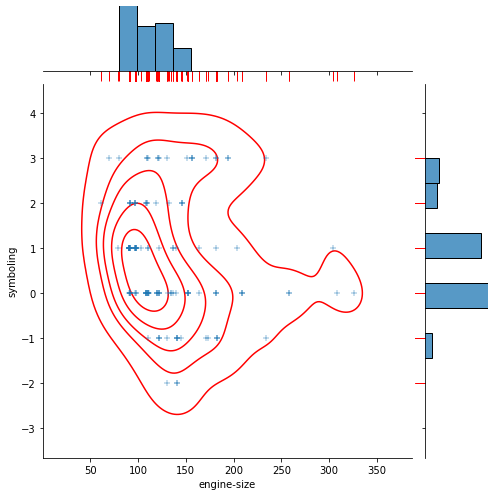

fuel-system


,fuel-system,len,mean,sum
5,mpfi,64,0.750000,48
1,2bbl,47,0.787234,37
3,idi,17,0.058824,1
0,1bbl,8,0.500000,4
6,spdi,5,1.800000,9
2,4bbl,1,3.000000,3
4,mfi,1,3.000000,3
7,spfi,1,2.000000,2


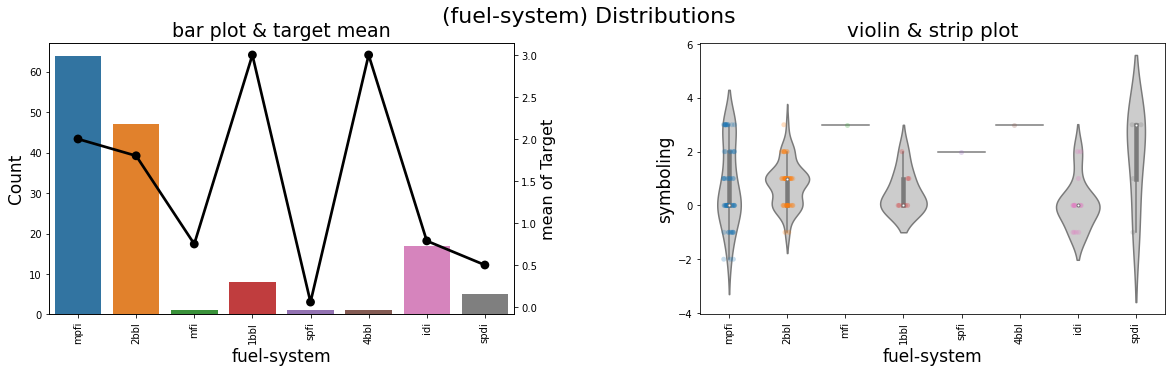

bore


,symboling,len,mean,max,min
2,0,52,3.398269,3.80,2.91
3,1,36,3.151389,3.94,2.91
5,3,19,3.484706,3.94,3.17
4,2,18,3.265000,3.62,2.91
1,-1,16,3.498125,3.78,3.01
0,-2,3,3.726667,3.78,3.62


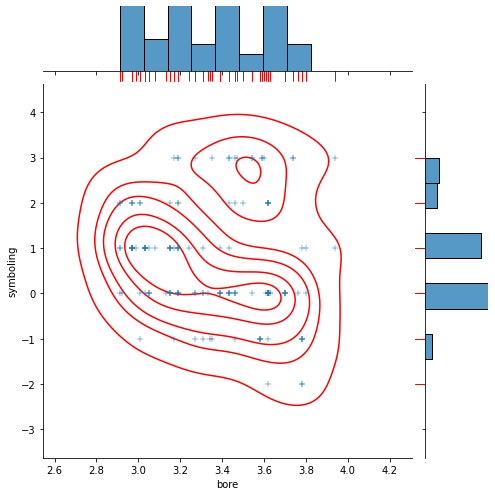

stroke


,symboling,len,mean,max,min
2,0,52,3.242308,4.17,2.19
3,1,36,3.245556,3.58,3.03
5,3,19,3.297647,3.90,2.68
4,2,18,3.247222,3.90,2.36
1,-1,16,3.331875,3.64,2.87
0,-2,3,3.150000,3.15,3.15


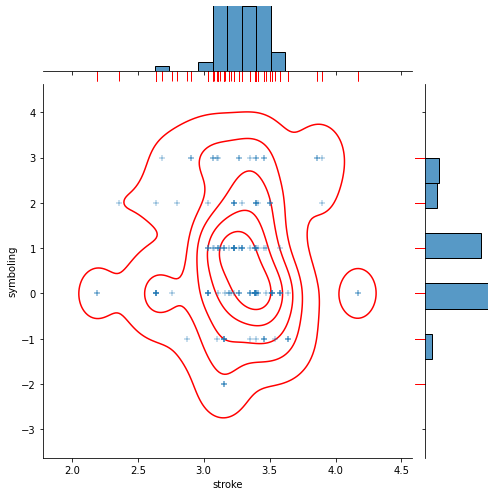

compression-ratio


,symboling,len,mean,max,min
2,0,52,11.223077,23.0,7.0
3,1,36,9.389167,21.9,7.5
5,3,19,8.579474,9.5,7.0
4,2,18,10.755556,23.0,8.7
1,-1,16,11.981250,23.0,7.5
0,-2,3,8.833333,9.5,7.5


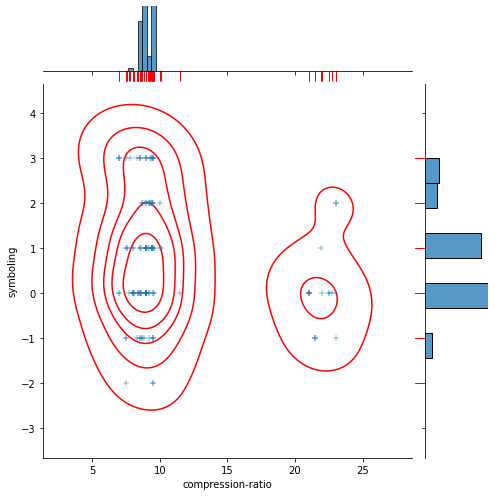

horsepower


,symboling,len,mean,max,min
2,0,52,105.500000,262.0,56.0
3,1,36,92.250000,288.0,55.0
5,3,19,140.473684,207.0,88.0
4,2,18,80.411765,116.0,48.0
1,-1,16,123.000000,162.0,88.0
0,-2,3,130.000000,162.0,114.0


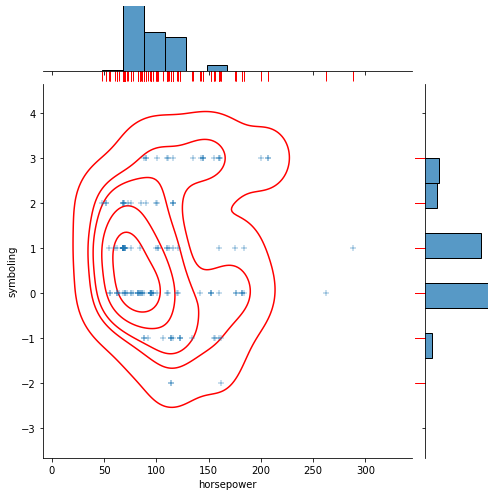

peak-rpm


,symboling,len,mean,max,min
2,0,52,4962.500000,6000.0,4150.0
3,1,36,5288.888889,6600.0,4250.0
5,3,19,5363.157895,6000.0,4750.0
4,2,18,5155.882353,6000.0,4400.0
1,-1,16,4975.000000,5500.0,4200.0
0,-2,3,5300.000000,5400.0,5100.0


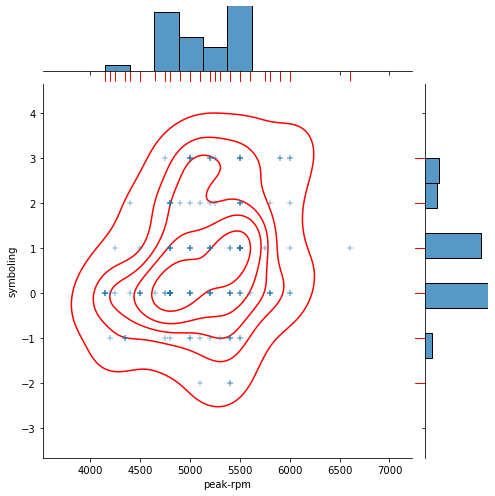

city-mpg


,symboling,len,mean,max,min
2,0,52,24.538462,38,13
3,1,36,28.694444,45,14
5,3,19,19.526316,25,16
4,2,18,29.666667,47,23
1,-1,16,21.687500,29,16
0,-2,3,21.333333,24,17


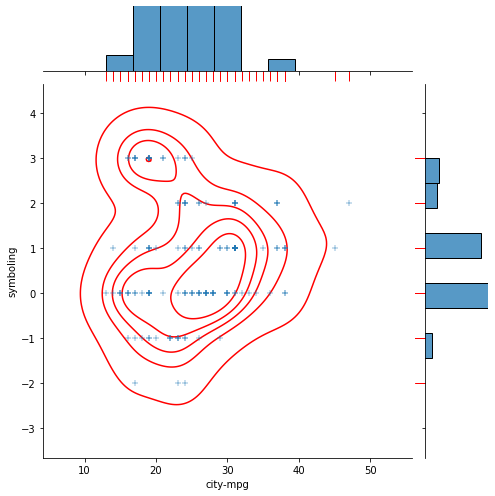

highway-mpg


,symboling,len,mean,max,min
2,0,52,29.750000,47,16
3,1,36,34.277778,50,16
5,3,19,25.578947,32,18
4,2,18,36.055556,53,29
1,-1,16,26.187500,34,18
0,-2,3,26.000000,28,22


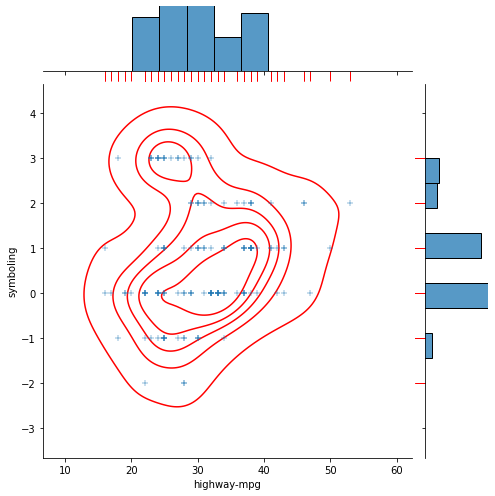

price


,symboling,len,mean,max,min
2,0,52,14845.137255,41315.0,6575.0
3,1,36,10132.000000,45400.0,5195.0
5,3,19,17772.157895,37028.0,8499.0
4,2,18,8337.944444,16430.0,5118.0
1,-1,16,19136.125000,34184.0,8921.0
0,-2,3,15781.666667,18420.0,12940.0


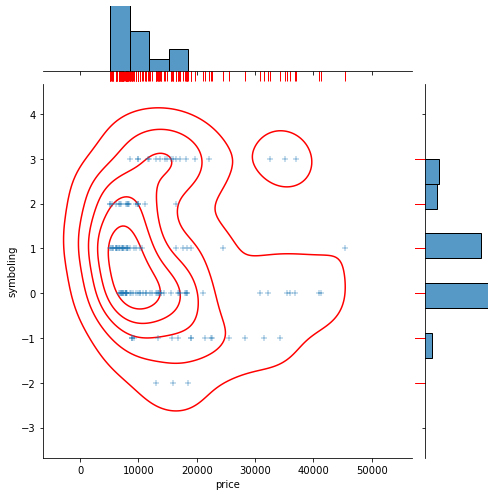

In [88]:
all_cols = train.columns.tolist()
all_cols = [i for i in all_cols if i not in [Target,'id']]

for col_name in all_cols:
    
    print(col_name)

    eda_plot(data=train,col_name=col_name,Target=Target)

> eda (pair of multiple features)

In [89]:
train.nunique().sort_values()

fuel-type              2
aspiration             2
engine-location        2
num-of-doors           3
drive-wheels           3
body-style             5
symboling              6
num-of-cylinders       7
engine-type            7
fuel-system            8
make                  22
peak-rpm              23
city-mpg              28
highway-mpg           29
compression-ratio     32
stroke                35
bore                  36
width                 42
engine-size           43
height                44
wheel-base            48
normalized-losses     50
horsepower            55
length                69
curb-weight          127
price                131
id                   144
dtype: int64

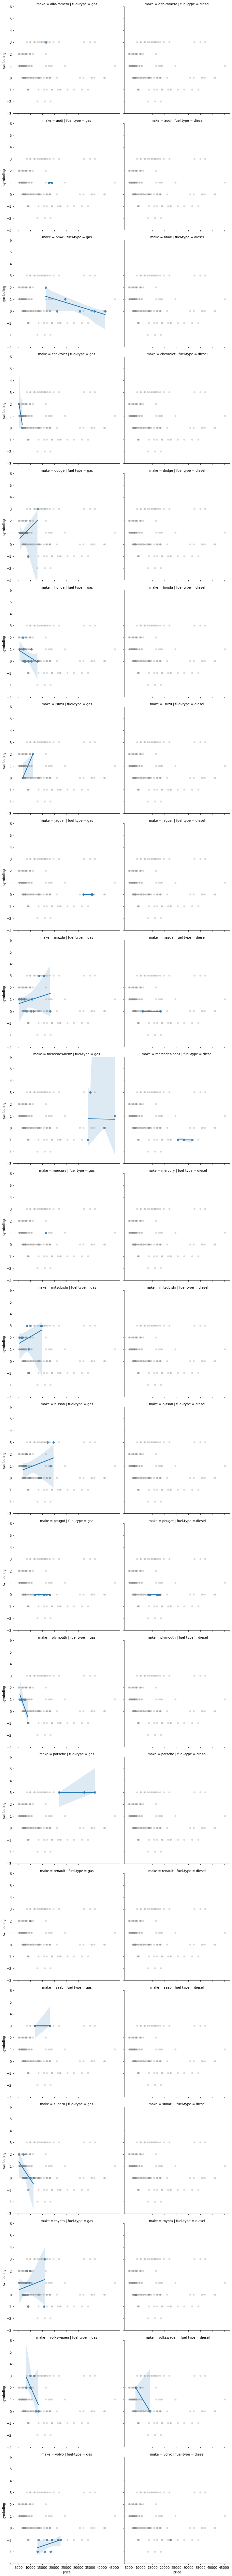

In [90]:
y = 'symboling'
x = 'price'
col = 'fuel-type'
row = 'make'

g = sns.lmplot(x=x, y=y, data=train, col=col, row=row)
g.set(ylim=(-3, 6))
  
axes = g.axes               
for ax in axes.ravel():     
    sns.regplot(x=x, y=y, data=train, fit_reg=False, scatter_kws={"fc":"gray", "ec":"none", "alpha":0.3}, ax=ax)

fig = g.fig
fig.tight_layout()

> eda (classification)

In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

def eda_plot(data,col_name,Target,hue=None,TopN=100):
    
    train_copy = data.copy()
    
    if data[col_name].dtype in ['object']:
        
        cat_col = col_name
        
        # select top N values in cat feature 
        top_values = train_copy[cat_col].value_counts().head(TopN).index.tolist()
        train_copy = train_copy.loc[train_copy[cat_col].isin(top_values),:].reset_index(drop=True)
    
        # plot figsize and title 
        plt.figure(figsize=(20,5))
        plt.suptitle('({cat_col}) Distributions'.format(cat_col=cat_col), fontsize=22)
        
        # check 
        a1 = train_copy.groupby(cat_col)[Target].agg([len,np.mean,np.sum]).reset_index().sort_values(['len'],ascending=False)
        display(a1.head(10))

        # target mean group by cat
        plt.subplot(121)
        g1 = sns.countplot(x=cat_col, data=train_copy)
        gt = g1.twinx()
        a1 = train_copy.groupby(cat_col)[Target].mean()
        a1 = a1.sort_index(ascending=False).reset_index()
        gt = sns.pointplot(x=cat_col, y=Target, data=a1, color='black', legend=False)
        gt.set_ylabel("mean of Target", fontsize=16)
        g1.set_title("bar plot & target mean", fontsize=19)
        g1.set_xlabel("{cat_col}".format(cat_col=cat_col), fontsize=17)
        g1.set_ylabel("Count", fontsize=17)
        g1.set_xticklabels(g1.get_xticklabels(),rotation=90)

        # boxplot 
        plt.subplot(122)
        ax = sns.stripplot(x=cat_col, y=Target, data=train_copy, dodge=True, jitter=True, alpha=.25)
        g3 = sns.violinplot(x=cat_col, y=Target, data=train_copy, ax=ax, color=".8")
        g3.set_title("violin & strip plot", fontsize=20)
        g3.set_xlabel("{cat_col}".format(cat_col=cat_col), fontsize=17)
        g3.set_ylabel("{Target}".format(Target=Target), fontsize=17)
        g3.set_xticklabels(g3.get_xticklabels(),rotation=90)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
        plt.show()
        
    elif data[col_name].dtype in [int,float]:
        
        num_col = col_name
        
        # check 
        a1 = train_copy.groupby(Target)[num_col].agg([len,np.mean,max,min]).reset_index().sort_values(['len'],ascending=False)
        display(a1.head(10))
        
        # jointplot 
        g2 = sns.jointplot(data=train_copy, x=num_col, y=Target, marker="+",height=7,hue=hue)
        g2.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
        g2.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

        plt.show()

In [92]:
train[Target].value_counts()

 0    52
 1    36
 3    19
 2    18
-1    16
-2     3
Name: symboling, dtype: int64

In [93]:
train['binary_target'] = np.where(train[Target]>0,1,0)
train['binary_target'].value_counts()

1    73
0    71
Name: binary_target, dtype: int64

>>  normalized-losses


,binary_target,len,mean,max,min
1,1,73,139.288136,256.0,83.0
0,0,71,106.388889,188.0,65.0


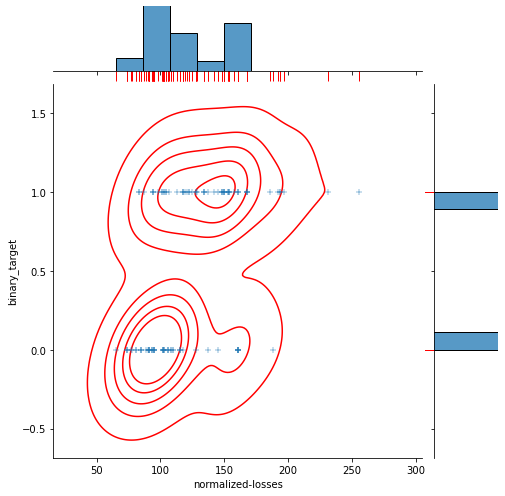

>>  make


,make,len,mean,sum
19,toyota,17,0.470588,8
12,nissan,13,0.692308,9
8,mazda,12,0.500000,6
21,volvo,10,0.000000,0
5,honda,10,0.400000,4
20,volkswagen,9,0.666667,6
13,peugot,9,0.000000,0
11,mitsubishi,9,0.888889,8
4,dodge,8,0.875000,7
18,subaru,8,0.250000,2


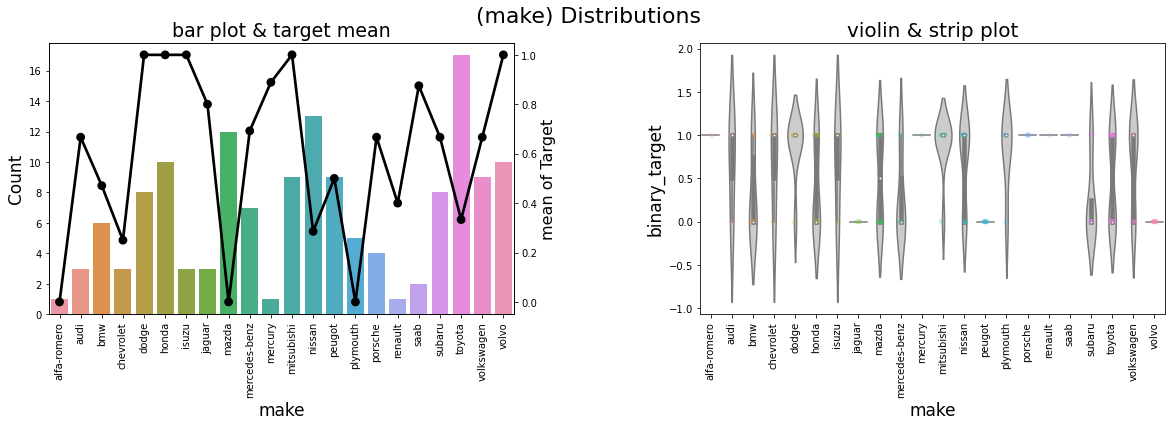

>>  fuel-type


,fuel-type,len,mean,sum
1,gas,127,0.551181,70
0,diesel,17,0.176471,3


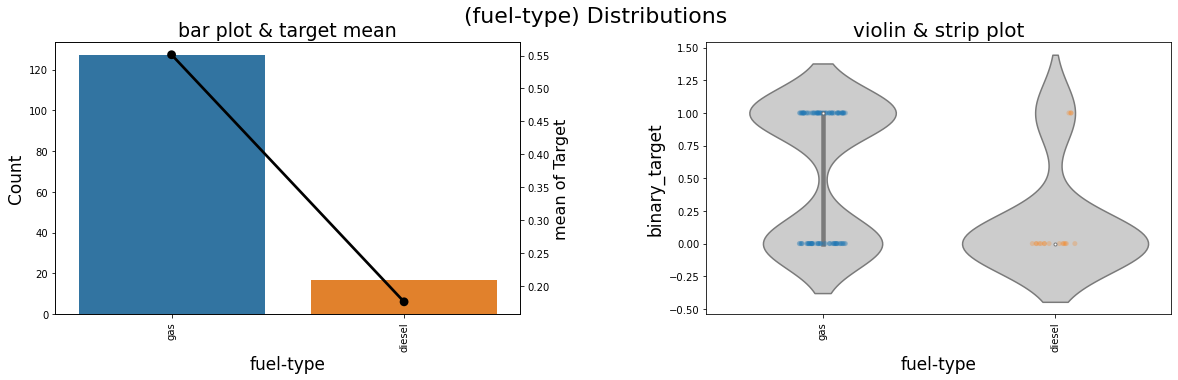

>>  aspiration


,aspiration,len,mean,sum
0,std,117,0.538462,63
1,turbo,27,0.370370,10


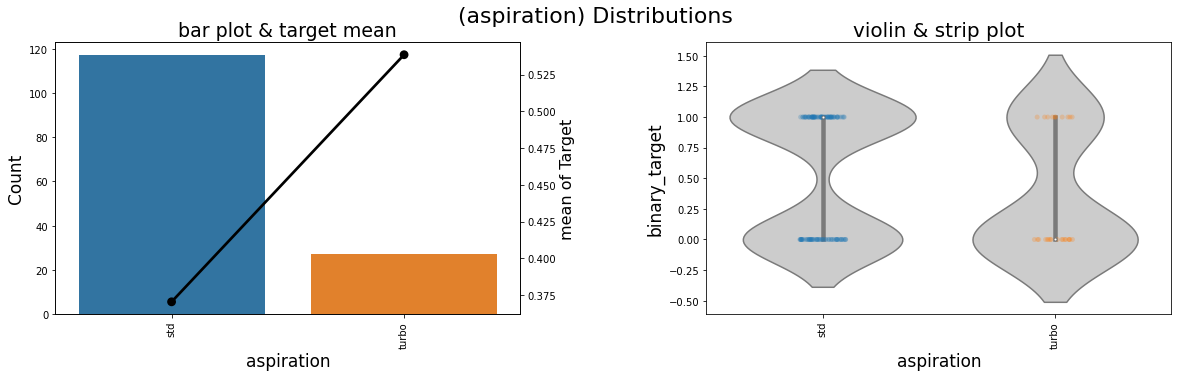

>>  num-of-doors


,num-of-doors,len,mean,sum
1,four,81,0.197531,16
2,two,61,0.918033,56
0,?,2,0.500000,1


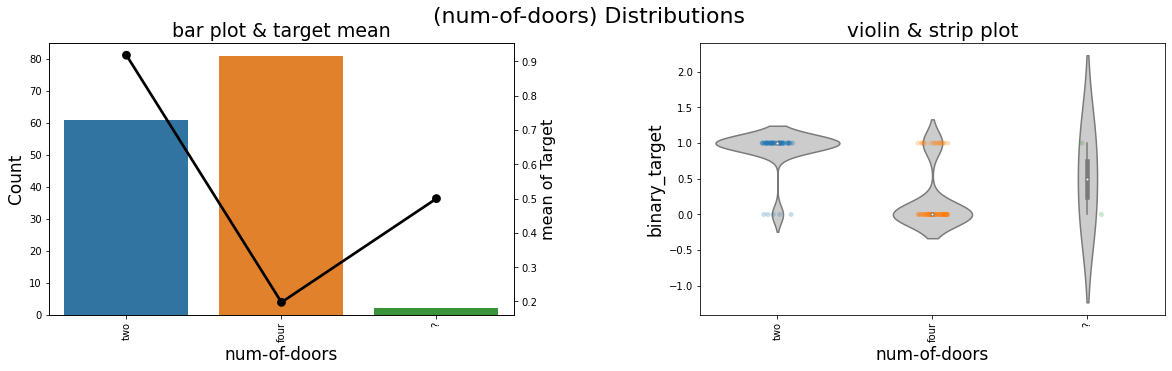

>>  body-style


,body-style,len,mean,sum
3,sedan,68,0.279412,19
2,hatchback,48,0.875000,42
4,wagon,19,0.157895,3
1,hardtop,5,1.000000,5
0,convertible,4,1.000000,4


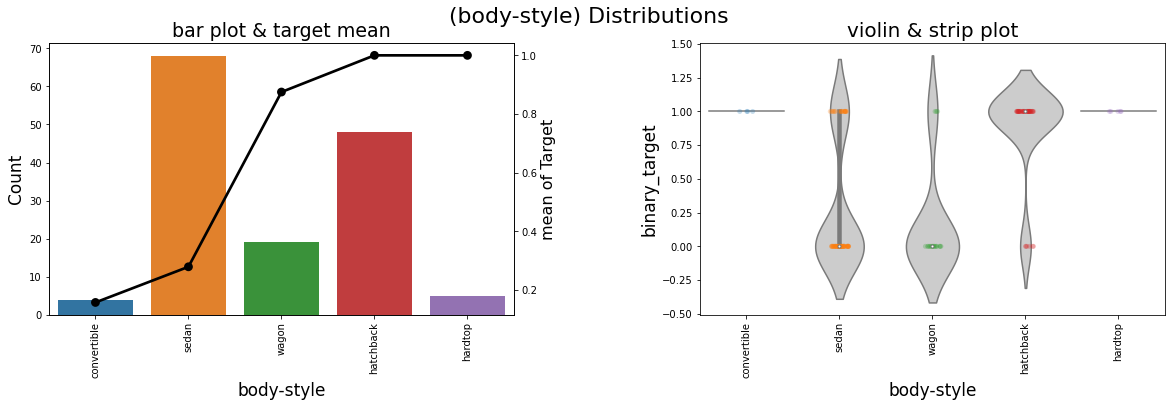

>>  drive-wheels


,drive-wheels,len,mean,sum
1,fwd,81,0.617284,50
2,rwd,58,0.396552,23
0,4wd,5,0.000000,0


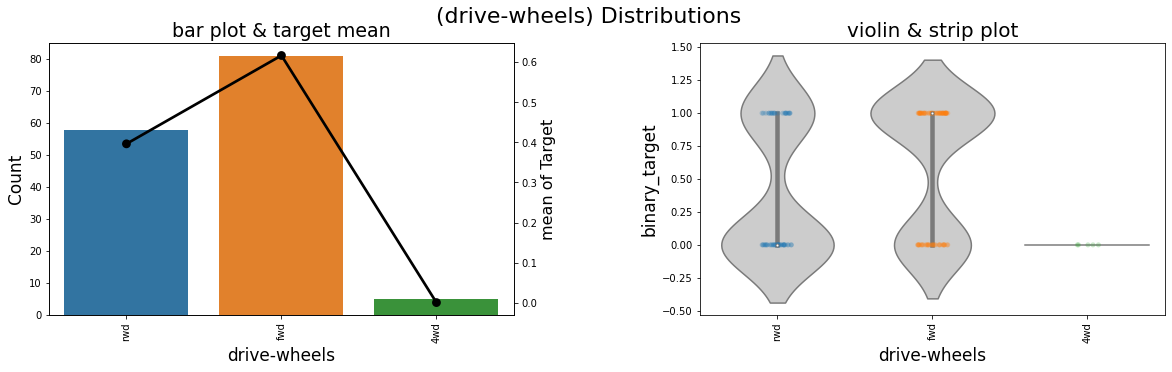

>>  engine-location


,engine-location,len,mean,sum
0,front,142,0.5,71
1,rear,2,1.0,2


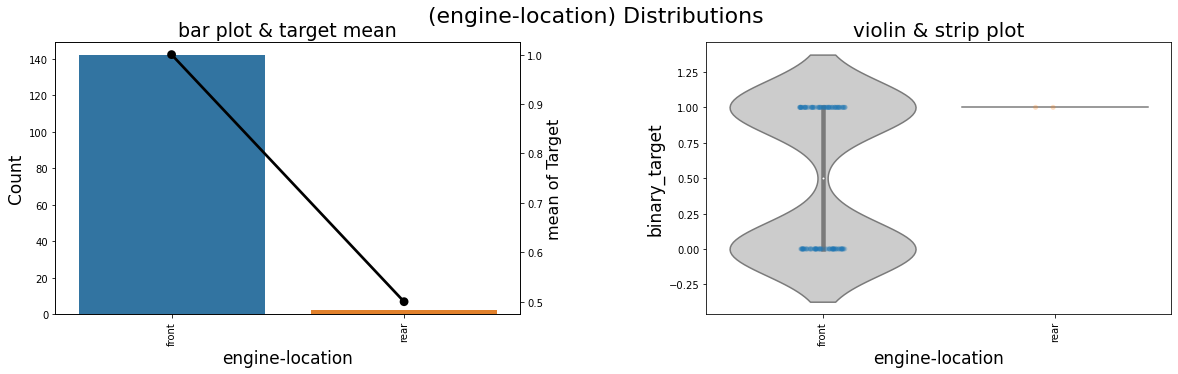

>>  wheel-base


,binary_target,len,mean,max,min
1,1,73,95.643836,112.0,86.6
0,0,71,102.950704,120.9,94.3


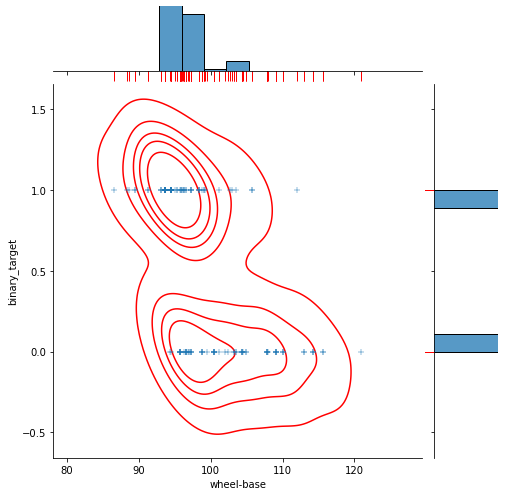

>>  length


,binary_target,len,mean,max,min
1,1,73,168.154795,199.2,141.1
0,0,71,181.477465,208.1,157.1


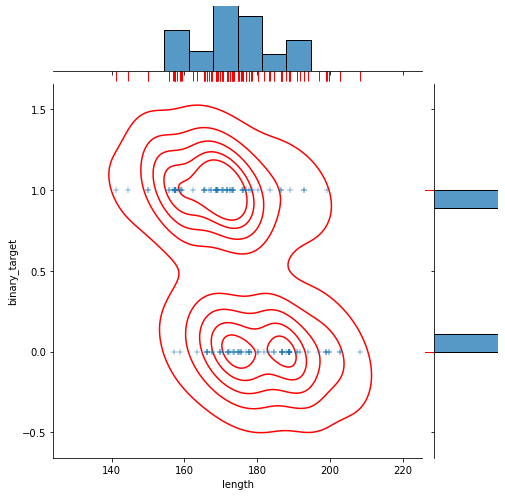

>>  width


,binary_target,len,mean,max,min
1,1,73,65.349315,72.3,60.3
0,0,71,66.805634,71.7,61.8


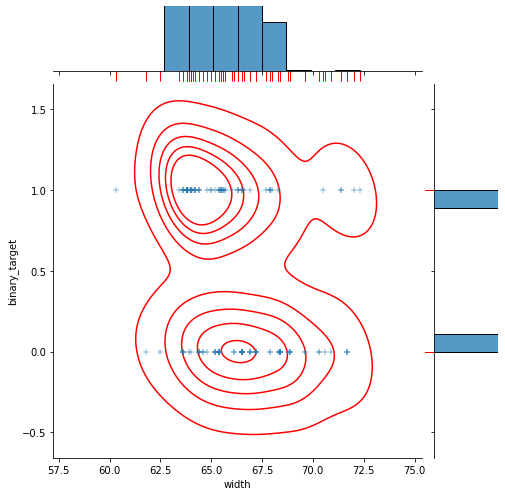

>>  height


,binary_target,len,mean,max,min
1,1,73,52.323288,56.1,48.8
0,0,71,55.264789,59.8,47.8


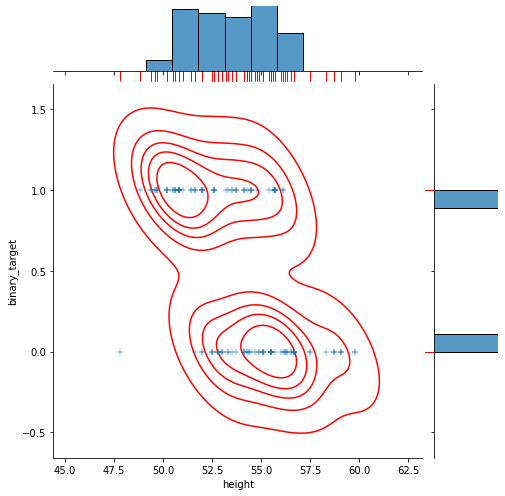

>>  curb-weight


,binary_target,len,mean,max,min
1,1,73,2364.945205,3715,1488
0,0,71,2840.732394,4066,1909


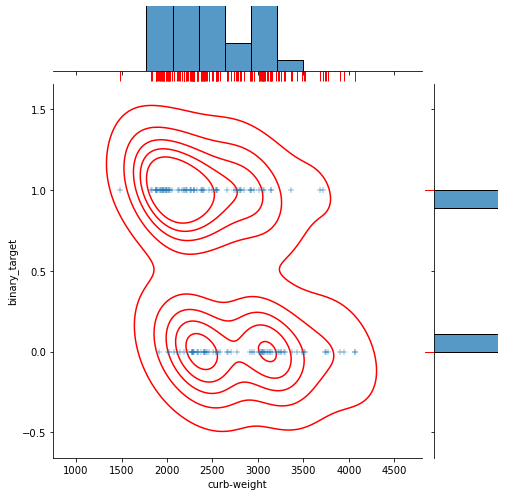

>>  engine-type


,engine-type,len,mean,sum
3,ohc,102,0.549020,56
5,ohcv,12,0.416667,5
2,l,10,0.100000,1
4,ohcf,10,0.400000,4
0,dohc,7,0.571429,4
6,rotor,2,1.000000,2
1,dohcv,1,1.000000,1


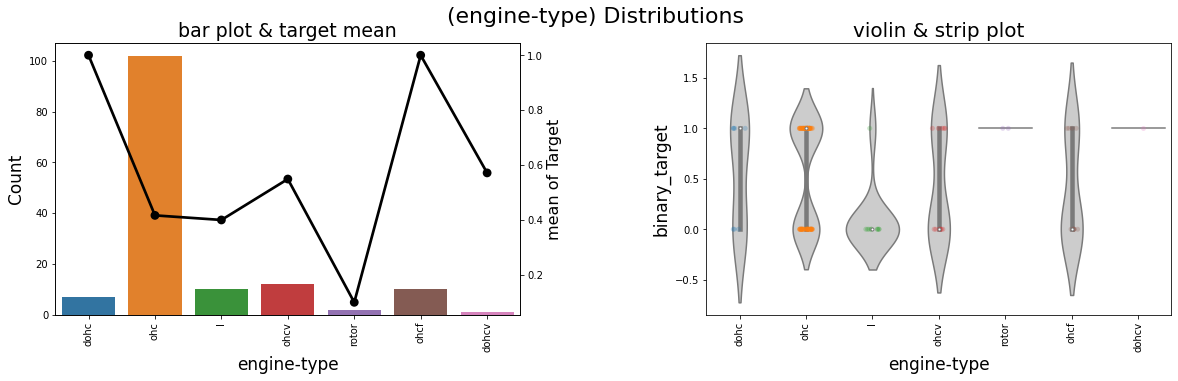

>>  num-of-cylinders


,num-of-cylinders,len,mean,sum
2,four,109,0.532110,58
3,six,19,0.368421,7
1,five,7,0.285714,2
0,eight,5,0.600000,3
6,two,2,1.000000,2
4,three,1,1.000000,1
5,twelve,1,0.000000,0


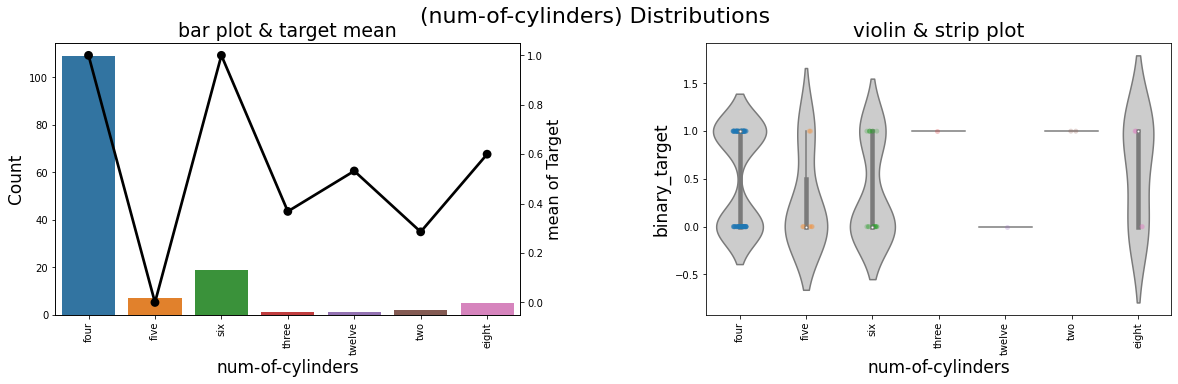

>>  engine-size


,binary_target,len,mean,max,min
1,1,73,119.410959,304,61
0,0,71,142.422535,326,90


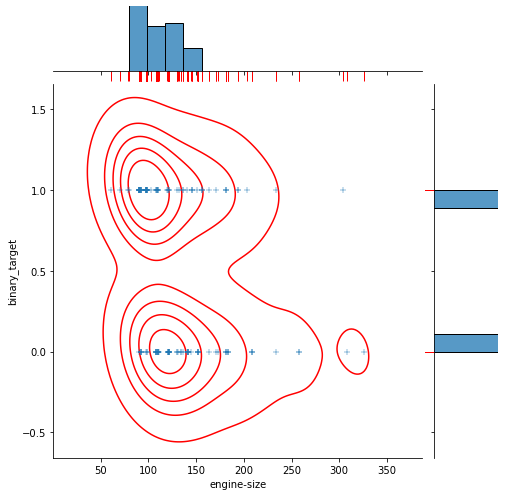

>>  fuel-system


,fuel-system,len,mean,sum
5,mpfi,64,0.468750,30
1,2bbl,47,0.638298,30
3,idi,17,0.176471,3
0,1bbl,8,0.375000,3
6,spdi,5,0.800000,4
2,4bbl,1,1.000000,1
4,mfi,1,1.000000,1
7,spfi,1,1.000000,1


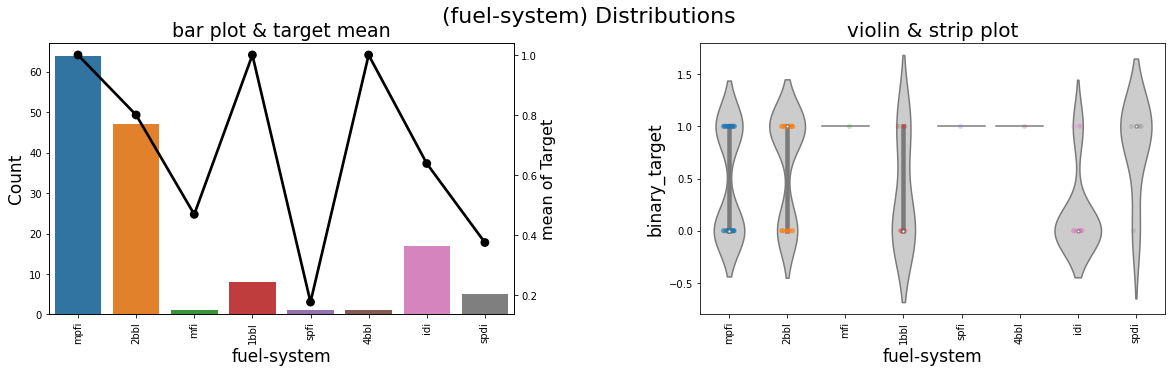

>>  bore


,binary_target,len,mean,max,min
1,1,73,3.260000,3.94,2.91
0,0,71,3.434648,3.80,2.91


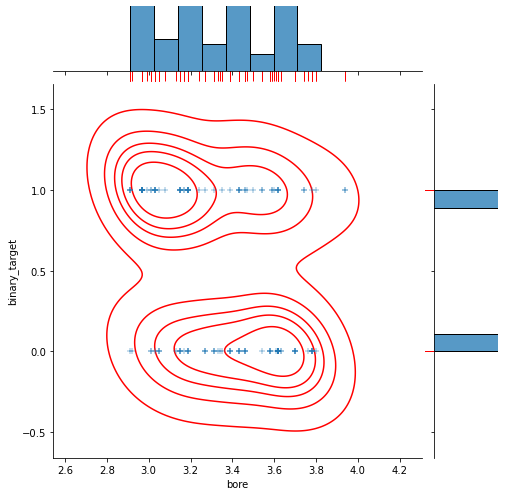

>>  stroke


,binary_target,len,mean,max,min
1,1,73,3.258451,3.90,2.36
0,0,71,3.258592,4.17,2.19


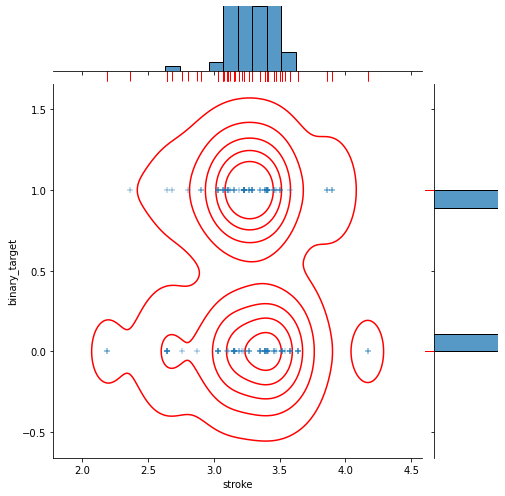

>>  compression-ratio


,binary_target,len,mean,max,min
1,1,73,9.515342,23.0,7.0
0,0,71,11.292958,23.0,7.0


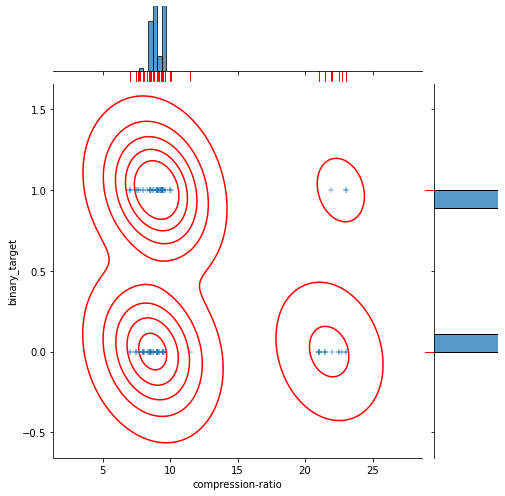

>>  horsepower


,binary_target,len,mean,max,min
1,1,73,102.180556,288.0,48.0
0,0,71,110.478873,262.0,56.0


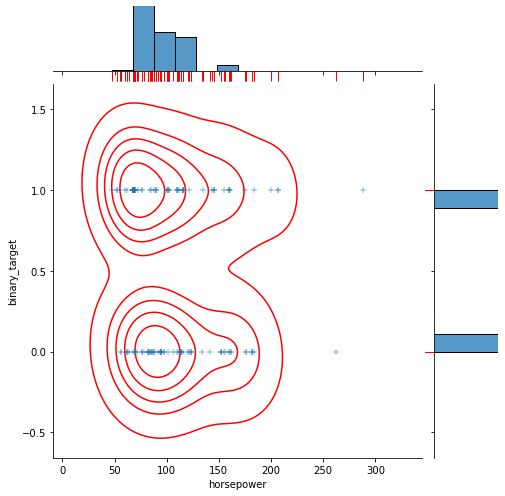

>>  peak-rpm


,binary_target,len,mean,max,min
1,1,73,5277.083333,6600.0,4250.0
0,0,71,4979.577465,6000.0,4150.0


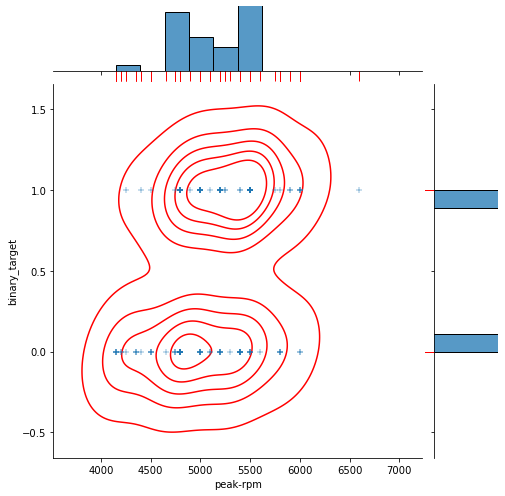

>>  city-mpg


,binary_target,len,mean,max,min
1,1,73,26.547945,47,14
0,0,71,23.760563,38,13


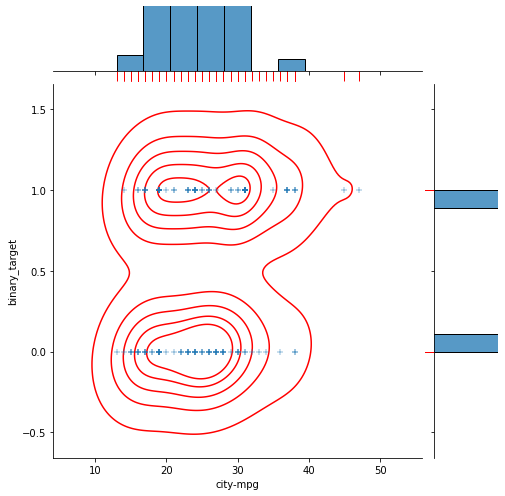

>>  highway-mpg


,binary_target,len,mean,max,min
1,1,73,32.452055,53,16
0,0,71,28.788732,47,16


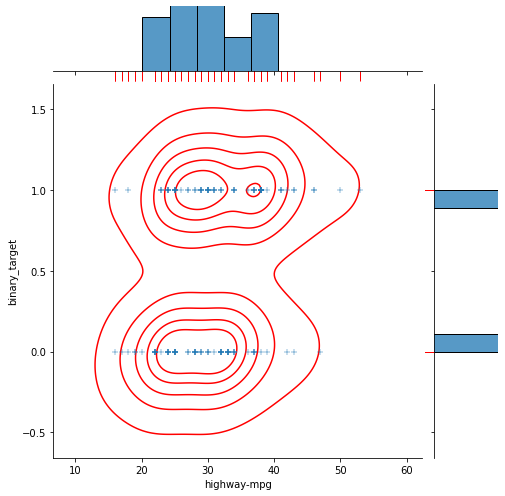

>>  price


,binary_target,len,mean,max,min
1,1,73,11721.718310,45400.0,5118.0
0,0,71,15866.071429,41315.0,6575.0


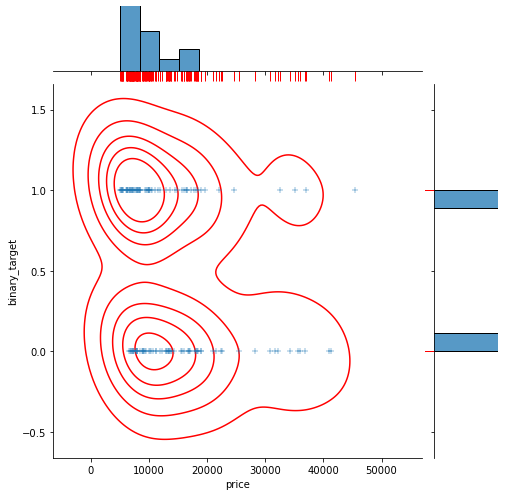

In [94]:
all_cols = train.columns.tolist()
all_cols = [i for i in all_cols if i not in [Target,'id','binary_target']]

for col_name in all_cols:
    
    print('>> ',col_name)

    eda_plot(data=train,col_name=col_name,Target='binary_target')

> pair of multiple features

make,audi,bmw,chevrolet,dodge,honda,jaguar,mazda,mercedes-benz,mitsubishi,nissan,peugot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
binary_target,,,,,,,,,,,,,,,,,,
0,NaN,188.0,81.0,110.000000,95.0,145.0,115.75,93.0,137.000000,112.500000,161.0,74.00,NaN,NaN,97.0,85.333333,NaN,93.2
1,158.0,192.0,109.5,134.714286,111.5,NaN,125.00,142.0,152.333333,152.333333,NaN,145.25,186.0,150.0,83.0,148.750000,132.0,NaN


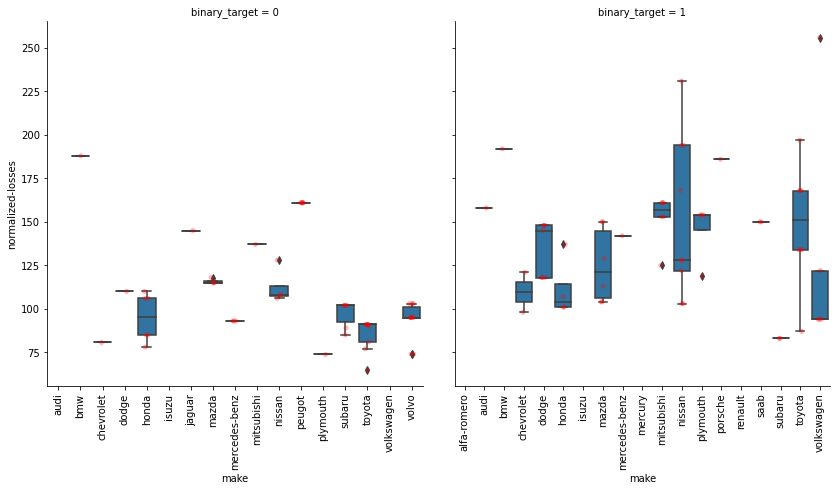

In [100]:
"""
y : numeric
x : category
"""

x = 'make'
y = 'normalized-losses'
col = 'binary_target'
hue = 'binary_target'
style = 'binary_target'

a1 = train.groupby([col,x])[y].mean().reset_index()
display(a1.pivot_table(columns='make',index='binary_target',values='normalized-losses'))

g2 = sns.FacetGrid(train, col=col, sharex=False,height=6)
g2.map_dataframe(sns.boxplot, x=x, y=y)
g2.map_dataframe(sns.stripplot, x=x, y=y,color="red",alpha=.3)

g2.set_xticklabels(rotation=90)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(<Figure size 576x576 with 4 Axes>,
 {0: <AxesSubplot:ylabel='Density'>,
  1: <AxesSubplot:>,
  2: <AxesSubplot:xlabel='make', ylabel='width'>,
  3: <AxesSubplot:xlabel='Density'>})

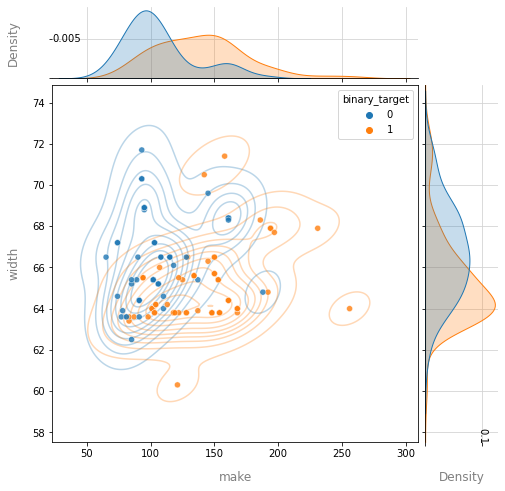

In [96]:
"""
y : numeric
x : numeric
"""

jointplots(
    xs = ["normalized-losses"], 
    y = "width",
    data = train, 
    hue = "binary_target", 
    height = 8, ratio=5, space=0.03, 
    xlabels = ["make"], 
    ylabel = "width"
)